# Overview
This is an example of how someone might generate and store models that can be compared for fairness. 

In [1]:
from IPython.display import Markdown
from fairMLHealth.utils import helpers, model_comparison
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


----
# Part 1 - Loading the Data <a class="anchor" id="part1"></a>


## Loading MIMIC III Data
As mentioned above, the MIMIC-III data download contains a folder of zipped_files. The tutorial code in the [Data Subset](#datasubset) section below will automatically unzip and format all necessary data for these experiments, saving the formatted data in the same MIMIC folder. Simply enter the correct path of the MIMIC folder in the following cell to enable this feature. Your path should end with the directory "MIMIC".

Example: path_to_mimic_data_folder = "~/data/MIMIC"

In [2]:
# path_to_mimic_data_folder = "[path to your downloaded data folder]"
path_to_mimic_data_folder = "~/data/MIMIC"

In [3]:
# output file for combined data and models
output_file = os.path.expanduser("~/data/fairness_and_bias/mimic_model_comparison/binary_classification.joblib")


## Data Subset <a id="datasubset"></a>
Example models in this notebook use data from all years of the MIMIC-III dataset for patients aged 65 and older. Data are imported at the encounter level with all additional patient identification dropped. All models include an "AGE" feature, simplified to 5-year bins, as well as boolean diagnosis and procedure features categorized through the Clinical Classifications Software system ([HCUP](https://www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp)). All features other than age are one-hot encoded and prefixed with their variable type (e.g. "GENDER_", "ETHNICITY_").  

In [4]:
df = helpers.load_example_data(path_to_mimic_data_folder) 
df = df.loc[df['AGE'].ge(65),:]
helpers.print_feature_table(df)
display(Markdown('---'))
display(df.head())


 This data subset has 22434 total observations and 649 input features 



,Raw Feature,Category Count (Encoded Features)
0,AGE,1
1,DIAGNOSIS,282
2,ETHNICITY,41
3,GENDER,2
4,INSURANCE,5
5,LANGUAGE,69
6,MARRIED,7
7,PROCEDURE,222
8,RELIGION,20


---

,ADMIT_ID,AGE,GENDER_F,GENDER_M,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETHNICITY_ASIAN,ETHNICITY_ASIAN - ASIAN INDIAN,ETHNICITY_ASIAN - CAMBODIAN,ETHNICITY_ASIAN - CHINESE,...,PROCEDURE_CCS_222,PROCEDURE_CCS_223,PROCEDURE_CCS_224,PROCEDURE_CCS_225,PROCEDURE_CCS_226,PROCEDURE_CCS_227,PROCEDURE_CCS_228,PROCEDURE_CCS_229,PROCEDURE_CCS_231,length_of_stay
0,762861,65.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.144444
1,749769,70.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,5.496528
2,721867,75.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.768056
5,795207,70.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,6.988889
7,760115,75.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,5.364583


,count,mean,std,min,25%,50%,75%,max
length_of_stay,22434.000000,9.115200,6.208700,0.004200,4.735200,7.579900,12.017700,29.988900
long_los,22434.000000,0.388000,0.487300,0.000000,0.000000,0.000000,1.000000,1.000000


---

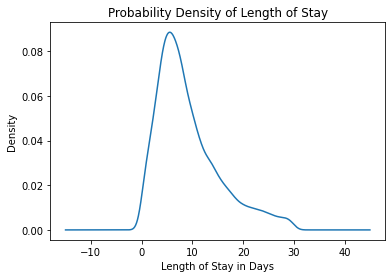

In [5]:
# Generate a binary target flagging whether an observation's length_of_stay value is above or below the mean. 
mean_val=df['length_of_stay'].mean()
df['long_los'] = df['length_of_stay'].apply(lambda x: 1 if x > mean_val else 0)
los_tbl = df[['length_of_stay', 'long_los']].describe().transpose().round(4)
display(los_tbl.style.applymap(helpers.highlight_col, subset=pd.IndexSlice[:, 'mean']))

# Display LOS distributions
display(Markdown('---'))
ax = df['length_of_stay'].plot(kind='kde', title="Probability Density of Length of Stay")
ax.set_xlabel("Length of Stay in Days")
plt.show()

----
# Part 2 - Train Length of Stay Models

In [6]:
# Shared Functions
from sklearn.model_selection import train_test_split
import sklearn.metrics as sk_metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from joblib import dump

## Baseline - Random Sampling

In [7]:
import random

# generate "predictions" as random sample of target values
y_test = df['long_los']
pos_weight = y_test.mean()
weights = [1-pos_weight, pos_weight]
values = y_test.unique()
y_pred_baseline = np.array(random.choices(values, weights, k=df.shape[0]))
y_prob_baseline = y_pred_baseline

# display baseline performance 
print("\n", "Prediction Scores for Random Sampling:", "\n", 
      sk_metrics.classification_report(y_test, y_pred_baseline, target_names=['LOS <= mean', 'LOS > mean']))


 Prediction Scores for Random Sampling: 
               precision    recall  f1-score   support

 LOS <= mean       0.61      0.61      0.61     13730
  LOS > mean       0.39      0.40      0.39      8704

    accuracy                           0.53     22434
   macro avg       0.50      0.50      0.50     22434
weighted avg       0.53      0.53      0.53     22434



## Split Data for other Models

In [8]:
# Subset and Split Data
X = df.loc[:,[c for c in df.columns if c not in ['length_of_stay', 'long_los']]]
y = df.loc[:, ['long_los']]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)



## Naive Bayes Classifier

In [9]:
from sklearn.naive_bayes import BernoulliNB

# Set model parameters (currently set as default values, but defined here to be explicit)
nb_params = {'alpha':1.0, 'binarize':0.0, 'fit_prior':True}

# Train Model
nb_model = BernoulliNB(**nb_params)
nb_model.fit(X_train, y_train.iloc[:,0])
y_pred_nb = nb_model.predict(X_test)

# display performance 
print("\n", "Naive Bayes Prediction Scores:", "\n", 
      sk_metrics.classification_report(y_test, y_pred_nb, target_names=['LOS <= mean', 'LOS > mean']))


 Naive Bayes Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.78      0.81      0.79      4531
  LOS > mean       0.68      0.64      0.66      2873

    accuracy                           0.74      7404
   macro avg       0.73      0.72      0.73      7404
weighted avg       0.74      0.74      0.74      7404



## Decision Tree Model

In [10]:
from sklearn.tree import DecisionTreeClassifier

# Set model parameters (currently set as default values, but defined here to be explicit)
dt_params = {}

# Train Model
dt_model = DecisionTreeClassifier(**dt_params)
dt_model.fit(X_train, y_train.iloc[:,0])
y_pred_dt = dt_model.predict(X_test)

# display performance 
print("\n", "Decision Tree Prediction Scores:", "\n", 
      sk_metrics.classification_report(y_test, y_pred_dt, target_names=['LOS <= mean', 'LOS > mean']) )


 Decision Tree Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.73      0.73      0.73      4531
  LOS > mean       0.57      0.57      0.57      2873

    accuracy                           0.67      7404
   macro avg       0.65      0.65      0.65      7404
weighted avg       0.67      0.67      0.67      7404



## Random Forest Model

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Set model parameters (currently set as default values, but defined here to be explicit)
rf_params = {}

# Train Model
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train, y_train.iloc[:,0])
y_pred_rf = rf_model.predict(X_test)

# display performance 
print("\n", "Random Forest Prediction Scores:", "\n", 
      sk_metrics.classification_report(y_test, y_pred_rf, target_names=['LOS <= mean', 'LOS > mean']) )


 Random Forest Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.76      0.91      0.83      4531
  LOS > mean       0.79      0.55      0.65      2873

    accuracy                           0.77      7404
   macro avg       0.78      0.73      0.74      7404
weighted avg       0.77      0.77      0.76      7404



## Logit Regression Model

In [12]:
from sklearn.linear_model import LogisticRegression

# Set model parameters (currently set as default values, but defined here to be explicit)
lr_params = {'max_iter':10**4}

# Train Model
lr_model = LogisticRegression(**lr_params)
lr_model.fit(X_train, y_train.iloc[:,0])
y_pred_lr = lr_model.predict(X_test)

# display performance 
print("\n", "Logit Regression Prediction Scores:", "\n", 
      sk_metrics.classification_report(y_test, y_pred_lr, zero_division=0, target_names=['LOS <= mean', 'LOS > mean']) )


 Logit Regression Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.61      1.00      0.76      4531
  LOS > mean       0.00      0.00      0.00      2873

    accuracy                           0.61      7404
   macro avg       0.31      0.50      0.38      7404
weighted avg       0.37      0.61      0.46      7404



## SVM Model

In [20]:
from sklearn.svm import LinearSVC 
import warnings
warnings.filterwarnings('ignore', message="Liblinear failed to converge, increase the number of iterations.")

# Set model parameters (currently set as default values, but defined here to be explicit)
svm_params = {'max_iter':10**4}

# Train Model
svm_model = LinearSVC(**svm_params)
svm_model.fit(X_train, y_train.iloc[:,0])
y_pred_svm = svm_model.predict(X_test)

# display performance 
print("\n", "SVM Prediction Scores:", "\n", 
      sk_metrics.classification_report(y_test, y_pred_svm, target_names=['LOS <= mean', 'LOS > mean'], zero_division=0) )


 SVM Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.61      1.00      0.76      4531
  LOS > mean       0.00      0.00      0.00      2873

    accuracy                           0.61      7404
   macro avg       0.31      0.50      0.38      7404
weighted avg       0.37      0.61      0.46      7404



## XGBOOST Model

In [14]:
from xgboost import XGBClassifier

# Set model parameters
xgb_params = {'colsample_bytree': 1.0, 'gamma': 2, 'learning_rate': 0.05, 'max_depth': 5, 
                'min_child_weight': 1,  'n_estimators': 600, 'subsample': 0.6}

# Train Model
xgb_model = XGBClassifier(**xgb_params)
xgb_model.fit(X_train, y_train.iloc[:,0])
y_pred_xgb = xgb_model.predict(X_test)

# display performance 
print("\n", "XGBOOST Prediction Scores:", "\n", 
      sk_metrics.classification_report(y_test, y_pred_xgb, target_names=['LOS <= mean', 'LOS > mean']) )



 XGBOOST Prediction Scores: 
               precision    recall  f1-score   support

 LOS <= mean       0.79      0.88      0.83      4531
  LOS > mean       0.77      0.63      0.69      2873

    accuracy                           0.78      7404
   macro avg       0.78      0.76      0.76      7404
weighted avg       0.78      0.78      0.78      7404



# Save Model Packet

In [22]:
models = {'naive_bayes_model':nb_model, 'decision_tree_model':dt_model, 'random_forest_model':rf_model, 'xgboost_model':xgb_model}
packet = model_comparison.fairCompare(test_data=X_test, target_data=y_test, models=models)
if not os.path.exists(os.path.dirname(output_file)):
        os.makedirs(output_file)
dump(packet, output_file)